Both datasets loaded successfully!

=== Three Different Days Dataset ===
Shape: (9, 24)
Columns: ['GM_Ksw_pred', 'GM_Ksw_gt', 'GM_MT_pred', 'GM_MT_gt', 'GM_B0_pred', 'GM_B0_gt', 'GM_B1_pred', 'GM_B1_gt', 'GM_T1_pred', 'GM_T1_gt', 'GM_T2_pred', 'GM_T2_gt', 'WM_Ksw_pred', 'WM_Ksw_gt', 'WM_MT_pred', 'WM_MT_gt', 'WM_B0_pred', 'WM_B0_gt', 'WM_B1_pred', 'WM_B1_gt', 'WM_T1_pred', 'WM_T1_gt', 'WM_T2_pred', 'WM_T2_gt']
First 3 rows:
   GM_Ksw_pred  GM_Ksw_gt  GM_MT_pred   GM_MT_gt  GM_B0_pred  GM_B0_gt  \
0        51.34  51.997961       13.51  12.834471      -0.013  0.005714   
1        51.21  51.254473       13.20  12.877423      -0.018 -0.002581   
2        49.88  50.844012       13.51  13.100942      -0.027 -0.000448   

   GM_B1_pred  GM_B1_gt  GM_T1_pred     GM_T1_gt  ...  WM_MT_pred   WM_MT_gt  \
0       0.986  1.000864     1479.98  1532.992955  ...       19.46  19.147686   
1       0.976  0.936629     1487.40  1499.160502  ...       18.63  18.079523   
2       0.974  0.984440     1456.77

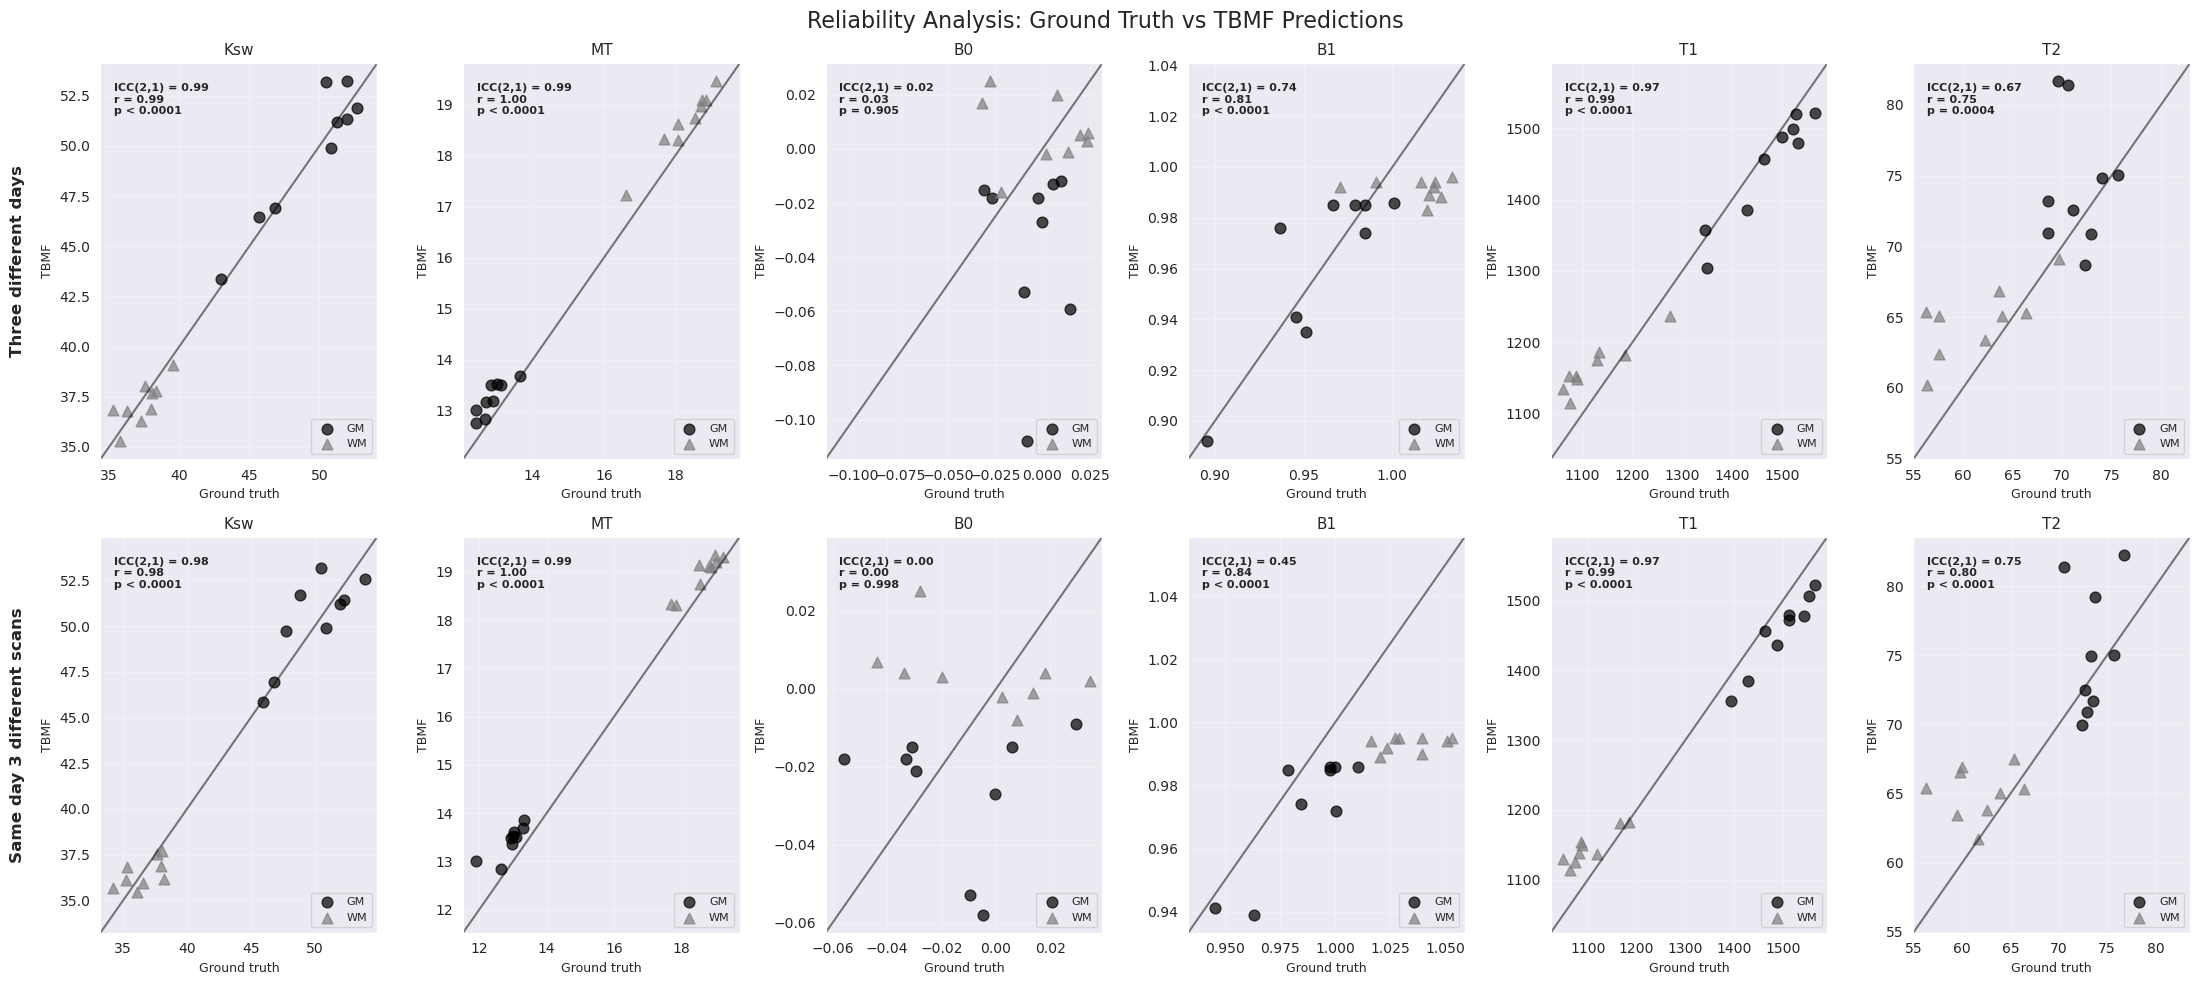

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pingouin as pg
from sympy.abc import alpha


def slicewise_icc(map1, map2, icctype='ICC2', debug=False):
    """ ICC3.1 measures "consistency" while ICC2.1 measures "absolute agreement".
    """
    import pingouin as pg
    if True:
        map1 = map1.flatten()
        map2 = map2.flatten()

        if debug:
            print(f"    Raw map1 (first 5): {map1[:5]}")
            print(f"    Raw map2 (first 5): {map2[:5]}")
            print(f"    map1 shape: {map1.shape}, map2 shape: {map2.shape}")
            print(f"    NaN in map1: {np.sum(np.isnan(map1))}, NaN in map2: {np.sum(np.isnan(map2))}")

        slice1 = map1[~np.isnan(map1) & ~np.isnan(map2)]
        slice2 = map2[~np.isnan(map1) & ~np.isnan(map2)]

        if debug:
            print(f"    After NaN removal - slice1 length: {len(slice1)}, slice2 length: {len(slice2)}")
            print(f"    slice1 (first 5): {slice1[:5]}")
            print(f"    slice2 (first 5): {slice2[:5]}")
            print(f"    slice1 range: [{np.min(slice1):.3f}, {np.max(slice1):.3f}]")
            print(f"    slice2 range: [{np.min(slice2):.3f}, {np.max(slice2):.3f}]")
            print(f"    Mean difference: {np.mean(slice1 - slice2):.3f}")
            print(f"    Std difference: {np.std(slice1 - slice2):.3f}")

        data = pd.DataFrame({
            'targets': np.repeat(np.arange(len(slice1)), 2),
            'raters': np.tile(['slice1', 'slice2'], len(slice1)),
            'ratings': np.concatenate([slice1, slice2])
        })

        if debug:
            print(f"    Data structure created:")
            print(f"    Data shape: {data.shape}")
            print(f"    First 10 rows:")
            print(data.head(10))
            print(f"    Unique targets: {data['targets'].nunique()}")
            print(f"    Unique raters: {data['raters'].unique()}")
            print(f"    Ratings range: [{data['ratings'].min():.3f}, {data['ratings'].max():.3f}]")

        # Compute the ICC
        icc = pg.intraclass_corr(data=data, targets='targets', raters='raters', ratings='ratings', nan_policy='omit')

        if debug:
            print(f"    Full ICC checkpoints:")
            print(icc)

        # Filter for correct type (ICC(2,1) / ICC(2,1)) and store the result
        icc_x = icc[icc['Type'] == icctype]
        if len(icc_x) == 0:
            if debug:
                print(f"    WARNING: No ICC type '{icctype}' found!")
                print(f"    Available types: {icc['Type'].tolist()}")
            return np.nan

        icc_result = icc_x['ICC'].values[0]

        if debug:
            print(f"    Selected ICC({icctype}): {icc_result:.4f}")
            print(f"    CI Lower: {icc_x['CI95%'].values[0][0]:.4f}")
            print(f"    CI Upper: {icc_x['CI95%'].values[0][1]:.4f}")

    return icc_result

def extract_data_for_parameter(df, param_cols, max_rows=9, debug=False):
    """
    Extract GT and predicted values for a given parameter from dataframe
    """
    gt_values = []
    pred_values = []
    tissue_types = []

    if debug:
        print(f"  Extracting data for parameter with columns: {param_cols}")
        print(f"  DataFrame shape: {df.shape}")

    for idx in range(min(max_rows, len(df))):
        if debug:
            print(f"    Row {idx}:")

        # Add GM data point
        if param_cols['GM_gt'] in df.columns and param_cols['GM_pred'] in df.columns:
            gm_gt = df.iloc[idx][param_cols['GM_gt']]
            gm_pred = df.iloc[idx][param_cols['GM_pred']]

            if debug:
                print(f"      GM: gt={gm_gt:.4f}, pred={gm_pred:.4f}, valid={not (pd.isna(gm_gt) or pd.isna(gm_pred))}")

            if not (pd.isna(gm_gt) or pd.isna(gm_pred)):
                gt_values.append(gm_gt)
                pred_values.append(gm_pred)
                tissue_types.append('GM')

        # Add WM data point
        if param_cols['WM_gt'] in df.columns and param_cols['WM_pred'] in df.columns:
            wm_gt = df.iloc[idx][param_cols['WM_gt']]
            wm_pred = df.iloc[idx][param_cols['WM_pred']]

            if debug:
                print(f"      WM: gt={wm_gt:.4f}, pred={wm_pred:.4f}, valid={not (pd.isna(wm_gt) or pd.isna(wm_pred))}")

            if not (pd.isna(wm_gt) or pd.isna(wm_pred)):
                gt_values.append(wm_gt)
                pred_values.append(wm_pred)
                tissue_types.append('WM')

    if debug:
        print(f"  Final extracted data:")
        print(f"    Total points: {len(gt_values)}")
        print(f"    GM points: {sum(1 for t in tissue_types if t == 'GM')}")
        print(f"    WM points: {sum(1 for t in tissue_types if t == 'WM')}")
        print(f"    GT values: {gt_values}")
        print(f"    Pred values: {pred_values}")
        print(f"    GT range: [{min(gt_values):.3f}, {max(gt_values):.3f}]")
        print(f"    Pred range: [{min(pred_values):.3f}, {max(pred_values):.3f}]")

    return gt_values, pred_values, tissue_types

def plot_reliability_subplot(ax, gt_values, pred_values, tissue_types, title, param_name, debug=False):
    """
    Create a single reliability subplot
    """
    if debug:
        print(f"\n=== DEBUGGING: {title} ===")

    if not gt_values or not pred_values or len(gt_values) < 2:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center',
                transform=ax.transAxes, fontsize=12)
        if debug:
            print(f"Insufficient data: gt_len={len(gt_values)}, pred_len={len(pred_values)}")
        return False

    if debug:
        print(f"Input data summary:")
        print(f"  GT values: {gt_values}")
        print(f"  Pred values: {pred_values}")
        print(f"  Tissue types: {tissue_types}")

    # Separate GM and WM points for plotting
    gm_indices = [j for j, tissue in enumerate(tissue_types) if tissue == 'GM']
    wm_indices = [j for j, tissue in enumerate(tissue_types) if tissue == 'WM']

    if debug:
        print(f"  GM indices: {gm_indices}")
        print(f"  WM indices: {wm_indices}")

    # Plot GM points
    if gm_indices:
        gm_gt = [gt_values[j] for j in gm_indices]
        gm_pred = [pred_values[j] for j in gm_indices]
        ax.scatter(gm_gt, gm_pred, c='black', marker='o', s=60, alpha=0.7, label='GM')
        if debug:
            print(f"  GM data: gt={gm_gt}, pred={gm_pred}")

    # Plot WM points
    if wm_indices:
        wm_gt = [gt_values[j] for j in wm_indices]
        wm_pred = [pred_values[j] for j in wm_indices]
        ax.scatter(wm_gt, wm_pred, c='gray', marker='^', s=60, alpha=0.7, label='WM')
        if debug:
            print(f"  WM data: gt={wm_gt}, pred={wm_pred}")

    # Add unity line
    all_values = gt_values + pred_values
    min_val = min(all_values)
    max_val = max(all_values)
    margin = (max_val - min_val) * 0.05
    ax.plot([min_val - margin, max_val + margin], [min_val - margin, max_val + margin], 'k-', alpha=0.5)

    # Calculate Pearson correlation coefficient and p-value
    try:
        pearson_r, pearson_p = stats.pearsonr(gt_values, pred_values)

        if debug:
            print(f"Pearson correlation: r = {pearson_r:.4f}, p = {pearson_p:.4f}")

        # Format p-value for display
        if pearson_p < 0.0001:
            p_text = "p < 0.0001"
        elif pearson_p < 0.001:
            p_text = f"p = {pearson_p:.4f}"
        else:
            p_text = f"p = {pearson_p:.3f}"

    except Exception as e:
        if debug:
            print(f"Pearson correlation calculation failed: {e}")
        pearson_r = np.nan
        p_text = "p = N/A"

    # Initialize statistics text components
    icc_text = "ICC = N/A"
    pearson_text = "r = N/A\np = N/A"

    # Calculate ICC with proper data structure
    if len(gm_indices) == len(wm_indices) and len(gm_indices) > 0:
        # Create proper ICC data structure for paired measurements
        icc_data = []

        # Add each subject's GM measurement pair
        for i, idx in enumerate(gm_indices):
            icc_data.append({
                'target': f'Subject_{i+1}_GM',
                'rater': 'GT',
                'rating': gt_values[idx]
            })
            icc_data.append({
                'target': f'Subject_{i+1}_GM',
                'rater': 'Predicted',
                'rating': pred_values[idx]
            })

        # Add each subject's WM measurement pair
        for i, idx in enumerate(wm_indices):
            icc_data.append({
                'target': f'Subject_{i+1}_WM',
                'rater': 'GT',
                'rating': gt_values[idx]
            })
            icc_data.append({
                'target': f'Subject_{i+1}_WM',
                'rater': 'Predicted',
                'rating': pred_values[idx]
            })

        df_icc = pd.DataFrame(icc_data)

        if debug:
            print(f"ICC data structure:")
            print(df_icc.head(12))
            print(f"Unique targets: {df_icc['target'].nunique()}")
            print(f"Unique raters: {df_icc['rater'].unique()}")

        try:
            # Calculate ICC directly using pingouin
            icc_result = pg.intraclass_corr(data=df_icc, targets='target', raters='rater',
                                           ratings='rating', nan_policy='omit')

            # Get ICC(2,1) value
            icc_row = icc_result[icc_result['Type'] == 'ICC2']
            if len(icc_row) > 0:
                icc_val = icc_row['ICC'].values[0]

                if debug:
                    print(f"ICC calculation successful:")
                    print(f"ICC(2,1) = {icc_val:.4f}")
                    print(f"Full ICC checkpoints:")
                    print(icc_result)

                icc_text = f'ICC(2,1) = {icc_val:.2f}'
            else:
                if debug:
                    print("No ICC2 type found in checkpoints")
                icc_text = 'ICC = N/A'

        except Exception as e:
            if debug:
                print(f"ICC calculation failed: {e}")
            icc_text = 'ICC = Error'
    else:
        if debug:
            print(f"Mismatched GM/WM data: GM={len(gm_indices)}, WM={len(wm_indices)}")

    # Format Pearson text
    if not np.isnan(pearson_r):
        pearson_text = f'r = {pearson_r:.2f}\n{p_text}'

    # Combine ICC and Pearson statistics in one box
    combined_text = f'{icc_text}\n{pearson_text}'

    # Display combined statistics (top left)
    ax.text(0.05, 0.95, combined_text,
           transform=ax.transAxes, fontsize=8, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0),
           verticalalignment='top')

    # Set equal aspect ratio and limits
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)
    ax.set_xlabel('Ground truth', fontsize=9)
    ax.set_ylabel('TBMF', fontsize=9)
    ax.set_title(title, fontsize=11)
    ax.grid(True, alpha=0.3)

    return True

def create_reliability_plots(df_days, df_scans, debug_param=None):
    """
    Create 2x6 subplot showing reliability plots for 6 parameters
    debug_param: specify parameter name to debug (e.g., 'Ksw')
    """
    # Define the 6 parameters with correct column names
    parameters = {
        'Ksw': {'GM_gt': 'GM_Ksw_gt', 'GM_pred': 'GM_Ksw_pred',
                'WM_gt': 'WM_Ksw_gt', 'WM_pred': 'WM_Ksw_pred'},
        'MT': {'GM_gt': 'GM_MT_gt', 'GM_pred': 'GM_MT_pred',
               'WM_gt': 'WM_MT_gt', 'WM_pred': 'WM_MT_pred'},
        'B0': {'GM_gt': 'GM_B0_gt', 'GM_pred': 'GM_B0_pred',
               'WM_gt': 'WM_B0_gt', 'WM_pred': 'WM_B0_pred'},
        'B1': {'GM_gt': 'GM_B1_gt', 'GM_pred': 'GM_B1_pred',
               'WM_gt': 'WM_B1_gt', 'WM_pred': 'WM_B1_pred'},
        'T1': {'GM_gt': 'GM_T1_gt', 'GM_pred': 'GM_T1_pred',
               'WM_gt': 'WM_T1_gt', 'WM_pred': 'WM_T1_pred'},
        'T2': {'GM_gt': 'GM_T2_gt', 'GM_pred': 'GM_T2_pred',
               'WM_gt': 'WM_T2_gt', 'WM_pred': 'WM_T2_pred'}
    }

    # Create the figure with subplots (2 rows x 6 columns)
    fig, axes = plt.subplots(2, 6, figsize=(22, 10))  # Increased figure size to accommodate additional text
    fig.suptitle('Reliability Analysis: Ground Truth vs TBMF Predictions', fontsize=16, y=0.98)

    param_names = list(parameters.keys())

    for j, param_name in enumerate(param_names):
        param_cols = parameters[param_name]

        # Enable debugging for specified parameter
        debug_mode = (debug_param == param_name) or (debug_param == 'all')

        if debug_mode:
            print(f"\n{'='*50}")
            print(f"DEBUGGING PARAMETER: {param_name}")
            print(f"{'='*50}")

        # Row 0: Three different days
        if debug_mode:
            print(f"\n--- THREE DIFFERENT DAYS ---")
        days_gt, days_pred, days_tissue = extract_data_for_parameter(
            df_days, param_cols, debug=debug_mode)
        has_data_days = plot_reliability_subplot(
            axes[0, j], days_gt, days_pred, days_tissue,
            f'{param_name}', param_name, debug=debug_mode)

        # Row 1: Same day different scans
        if debug_mode:
            print(f"\n--- SAME DAY DIFFERENT SCANS ---")
        scans_gt, scans_pred, scans_tissue = extract_data_for_parameter(
            df_scans, param_cols, debug=debug_mode)
        has_data_scans = plot_reliability_subplot(
            axes[1, j], scans_gt, scans_pred, scans_tissue,
            f'{param_name}', param_name, debug=debug_mode)

        # Add legends to all subplots that have data
        if has_data_days:
            axes[0, j].legend(loc='lower right', fontsize=8)
        if has_data_scans:
            axes[1, j].legend(loc='lower right', fontsize=8)

    # Add row labels on the left side
    axes[0, 0].text(-0.3, 0.5, 'Three different days', rotation=90,
                    transform=axes[0, 0].transAxes, fontsize=12, fontweight='bold',
                    verticalalignment='center', horizontalalignment='center')
    axes[1, 0].text(-0.3, 0.5, 'Same day 3 different scans', rotation=90,
                    transform=axes[1, 0].transAxes, fontsize=12, fontweight='bold',
                    verticalalignment='center', horizontalalignment='center')

    plt.tight_layout()
    return fig

def print_data_summary(df, dataset_name):
    """
    Print summary of the dataset
    """
    print(f"\n=== {dataset_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("First 3 rows:")
    print(df.head(3))
    print("Data types:")
    print(df.dtypes.value_counts())

# Main execution
if __name__ == "__main__":
    try:
        # Load both datasets
        df_days = pd.read_excel("/home/sahar/Models/Dinor_revision/new_phantom/dinor_train/code_addition/human/Results_human/Tables_for_gm_and_wm_vs_GT/Days_gt_vs_predict.xlsx")
        df_scans = pd.read_excel("/home/sahar/Models/Dinor_revision/new_phantom/dinor_train/code_addition/human/Results_human/Tables_for_gm_and_wm_vs_GT/In_day_vs_gt.xlsx")

        print("Both datasets loaded successfully!")

        # Print summaries
        print_data_summary(df_days, "Three Different Days Dataset")
        print_data_summary(df_scans, "Same Day Different Scans Dataset")

        # Create the plots with debugging for specific parameters
        # Change 'Ksw' to 'all' to debug all parameters, or specify another parameter
        fig = create_reliability_plots(df_days, df_scans, debug_param='T2')

        # Save the figure
        plt.savefig('reliability_analysis_combined_stats.png', dpi=300, bbox_inches='tight')
        plt.savefig('reliability_analysis_combined_stats.pdf', bbox_inches='tight')

        print(f"\n✓ Plots saved as 'reliability_analysis_combined_stats.png' and '.pdf'")
        plt.show()

    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()